In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import random as rd

%matplotlib inline

In [3]:
def processMarkovLen(init):
    temp = []
    zeros = 0
    for i, v in enumerate(init):
        if(v == 0):
            zeros = zeros+1
            v = 2
        if(i>1):
            if(v==1):
                temp.append(init[i-1])
    temp.append(v)
    
    final = list(np.ones(int(temp[0]+1+zeros))*temp[0])
    for i in range(len(temp)-1):
        final += list(np.linspace(int(temp[i]), int(temp[i+1]), int(temp[i+1]+1)))[1:]
    return np.asarray(final)

In [4]:
def processDataDSA(pathTXT):
    acceptance_pb = []
    acc_best_sol = []
    temp = []
    density = []
    markov_len = []
    best_y = []
    curr_y = []
    runtime = 0
    iteration_nbr = 0
    
    with open(pathTXT, "r") as file:
        dimension = file.readline().count('BEST x')
        best_xs = np.zeros((dimension, 0))
        curr_xs = np.zeros((dimension, 0))

        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                final = 7
                a = line.split("|")
                a = [i.strip() for i in a][:-1]
                if(float(a[5])!=0):
                    acceptance_pb.append(float(a[0]))
                    acc_best_sol.append(a[1])
                    temp.append(float(a[2]))
                    density.append(float(a[3]))
                    markov_len.append(float(a[4]))
                    best_y.append(float(a[5]))
                    if(float(a[6])>10e6):
                        curr_y.append(60.0)
                    else: 
                        curr_y.append(float(a[6]))

                    best_xs_temp = np.zeros((dimension, 1))
                    curr_xs_temp = np.zeros((dimension, 1))
                    for i in range(dimension):
                        index = i*2
                        best_xs_temp[i] = float(a[final+index+1])
                        curr_xs_temp[i] = float(a[final+index])
                    best_xs = np.concatenate((best_xs, best_xs_temp), axis = 1)
                    curr_xs = np.concatenate((curr_xs, curr_xs_temp), axis = 1)
                
    acceptance_pb = np.asarray(acceptance_pb)
    acc_best_sol = np.asarray(acc_best_sol)
    temp = np.asarray(temp)
    best_y = np.asarray(best_y)
    curr_y = np.asarray(curr_y)
    
    density = np.asarray(density)
    markov_len = processMarkovLen(markov_len)[:len(temp)]
    
    
    return acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr

In [5]:
def drawPlotDSA(plotAll, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor, density_factor):
    set_matplotlib_formats('retina')

    x = np.arange(len(best_y))
    string = str(prob_factor)
    string2 = str(density_factor)
        
    line1, = plt.plot(x, best_y, color='g')
    if(plotAll):
        line2, = plt.plot(x, temp, color='orange')
        line3, = plt.plot(x, markov_len, color='grey')
        line5, = plt.plot(x, density*density_factor, color='purple')
        plt.scatter(x, acceptance_pb*prob_factor, s=1, marker='+', label='Acceptance proba x'+string, color='pink')
        line2.set_label('Temperature')
        line3.set_label('Actual MarkovChains Length')
        line5.set_label('CG Density x'+string2)
        
    plt.scatter(x, curr_y, s=3, marker=">", label='Current Solution', color='blue')


    line1.set_label('Best Solution')
    plt.savefig('../resources/foo.png', format='png', dpi=333)

    fig = plt.gcf()
    fig.set_size_inches(13,10)

    plt.legend()
    plt.yscale('log')
    plt.show()


# Improvement functions

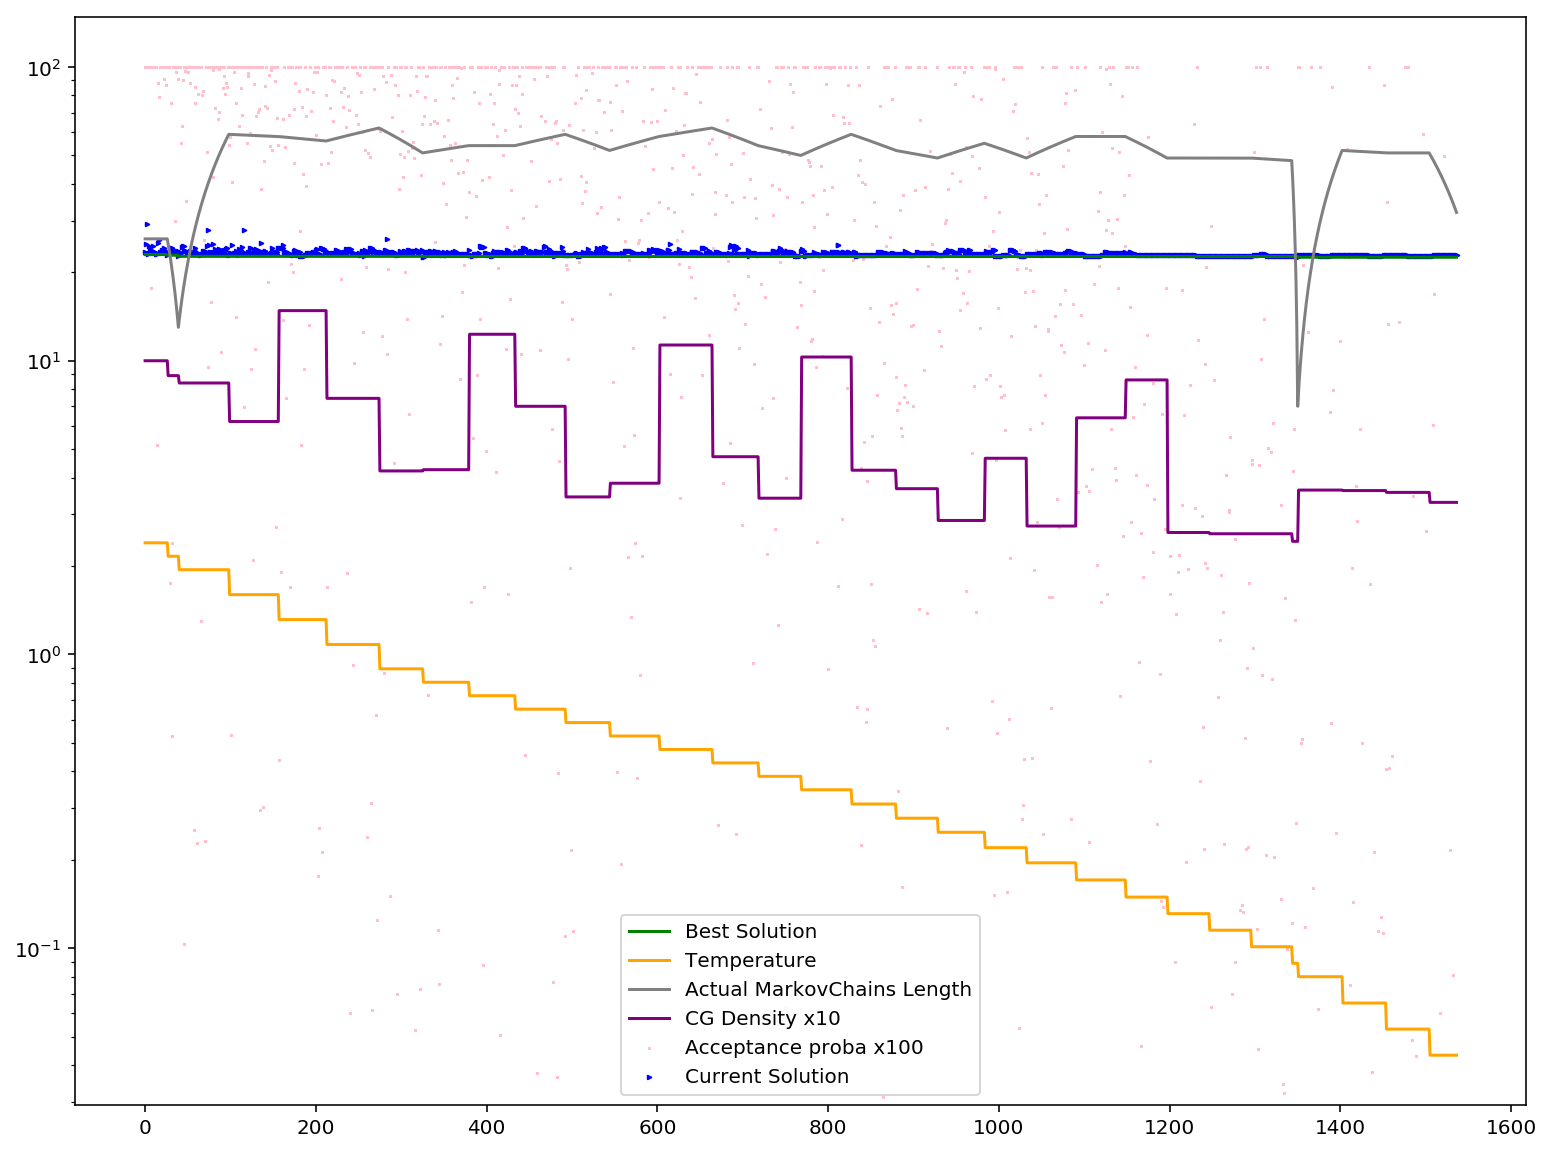

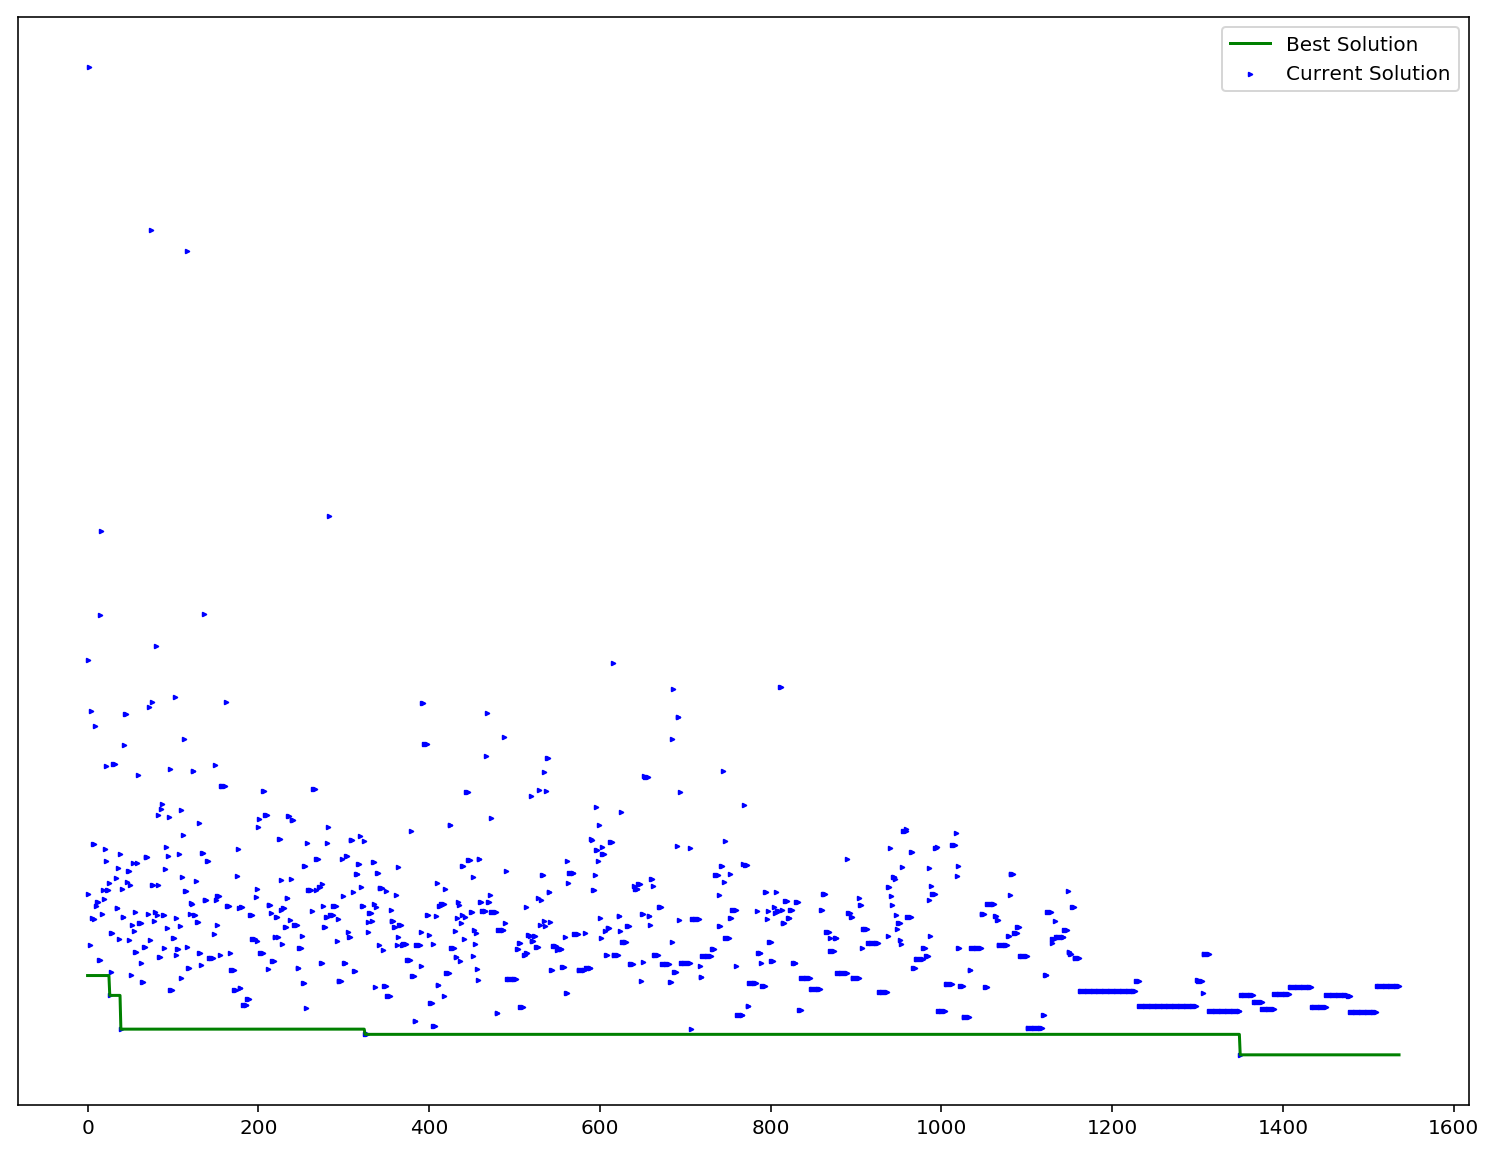

In [6]:
path = "../../../../GraphsSimu/data_to_visualize/with-density/DSA_results_tp0OXT8cV.txt"
acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr = processDataDSA(path)

drawPlotDSA(True, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor=100, density_factor=10)
drawPlotDSA(False, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor=100, density_factor=10)


# Plot the function 

All current solution greater than 30 are now equal to 30, we want to eliminate them !

In [7]:
import pandas as pd

def processData(pathTXT):
    a = []
    tab = []
    i = 0
    with open(pathTXT, "r") as file:
        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                a = line.split("|")[5:]
                a = [i.strip() for i in a][:-1]
                if(i!=0):
                    a = [float(i) for i in a]
                tab.append(a)
            i+=1
            
    titles = tab[0] 
    #print(titles)
    dtf = pd.DataFrame(data=tab[1:],columns=titles)
    
    isNotInit = dtf['BEST y']!=0.0
    dtf_all = dtf[isNotInit]
    
    aa = np.array(dtf_all['CURR y'].values.tolist())
    dtf_all['CURR y'] = [v if v < 30 else 30 for v in aa]


    col_to_del = [titles[0]]+titles[2::2]
    afterdrop_cur = dtf_all.drop(col_to_del, axis = 1)
    col_to_del = [titles[1]]+titles[3::2]
    afterdrop_bes = dtf_all.drop(col_to_del, axis = 1)
    
    
    return dtf_all, afterdrop_cur, afterdrop_bes

In [8]:
data, data_cur1, data_best = processData('../../../../GraphsSimu/data_to_visualize/with-density/DSA_results_Fo1tSl72E.txt')
data, data_cur2, data_best = processData('../../../../GraphsSimu/data_to_visualize/with-density/DSA_results_irgySkwQ2.txt')
data, data_cur3, data_best = processData('../../../../GraphsSimu/data_to_visualize/with-density/DSA_results_jHiGyH8pD.txt')

data_cur1 = data_cur1.dropna().drop_duplicates(keep='first').sort_values(by=['CURR y'])[:133]
data_cur2 = data_cur2.dropna().drop_duplicates(keep='first').sort_values(by=['CURR y'])[:133]
data_cur3 = data_cur3.dropna().drop_duplicates(keep='first').sort_values(by=['CURR y'])[:134]

data_curs = data_cur1.append(data_cur2).append(data_cur3).sort_values(by=['CURR y'])[:50]



#data_cur = data_cur.sort_values(by=['CURR y'])
#data_cur = data_cur.drop_duplicates(keep='first')
data_cur3.head()

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CURR y,CURR x,CURR x2,CURR x3,CURR x4
51,22.444155,10.360529,3.949585,-1.909217,5.178496
371,22.657900,18.314803,1.434713,-2.084888,4.455722
991,22.711432,15.457041,0.948860,-1.328519,5.256530
1037,22.757851,11.414322,2.861733,-2.532081,4.507305
55,22.767589,9.445229,2.434034,-0.355188,3.430847


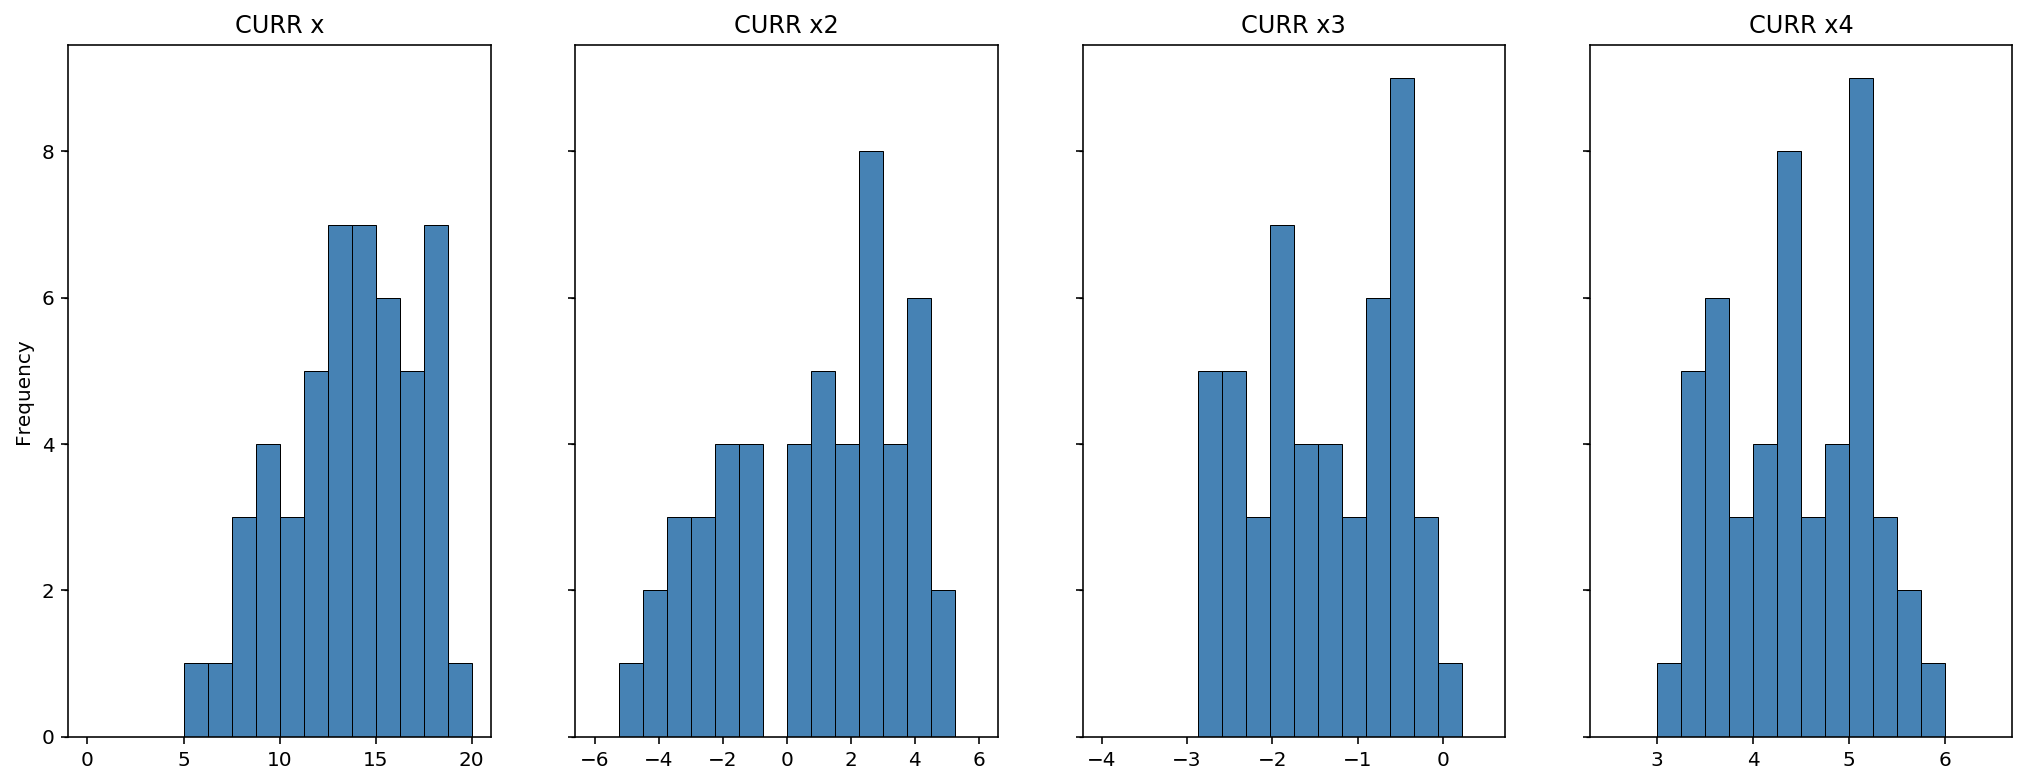

In [9]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20, 6))

data_curs['CURR x'].plot.hist(bins=16, ax=ax1, color='steelblue', edgecolor='black', linewidth=0.5, range=[0,20]) 
f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
data_curs['CURR x2'].plot.hist(bins=16, ax=ax2, color='steelblue', edgecolor='black', linewidth=0.5, range=[-6,6]) 
f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
data_curs['CURR x3'].plot.hist(bins=16, ax=ax3, color='steelblue', edgecolor='black', linewidth=0.5, range=[-4,0.5]) 
f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
data_curs['CURR x4'].plot.hist(bins=16, ax=ax4, color='steelblue', edgecolor='black', linewidth=0.5, range=[2.5,6.5]) 
f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

ax1.set_title('CURR x')
ax2.set_title('CURR x2') 
ax3.set_title('CURR x3')
ax4.set_title('CURR x4')

plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)


In [10]:
import seaborn as sns

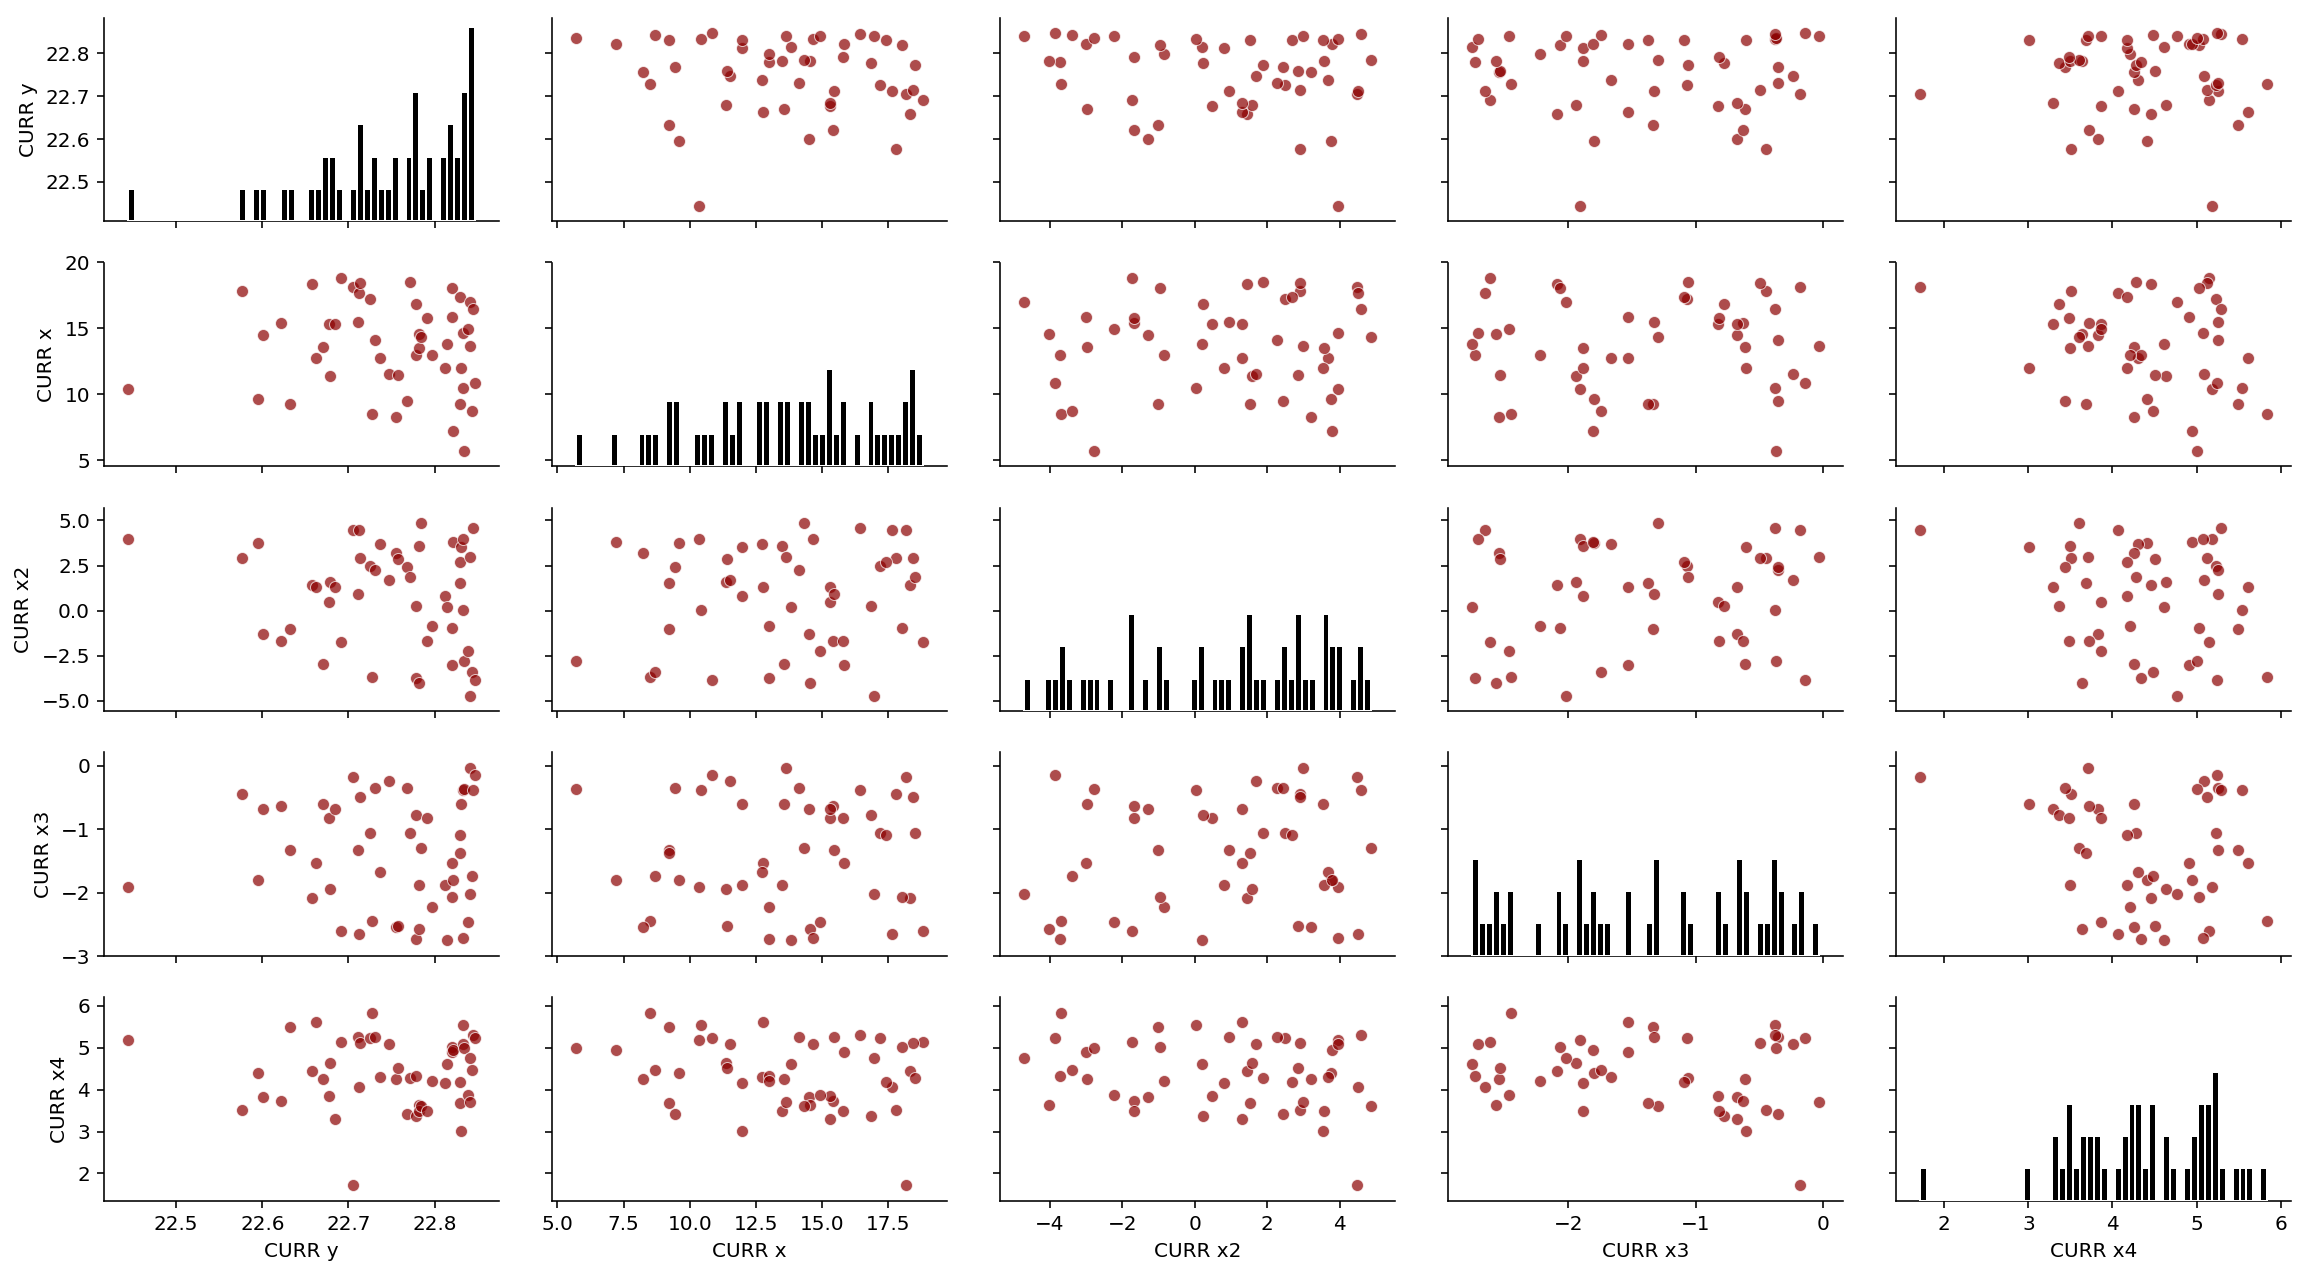

In [11]:
pp = sns.pairplot(data_curs, height=1.8, aspect=1.8,
                  plot_kws={'edgecolor':"k", 'linewidth':0.5, 'alpha':0.7, 'edgecolor': 'w', 'color':'darkred'},
                  diag_kind="hist", diag_kws={'bins':50, 'color':'black', 'edgecolor': 'w'})

#pp.savefig('../resources/foo.png', format='png', dpi=333)

# Parallel Coordinates

In [12]:
import matplotlib.colors as colors

def truncate_colormap(cmap_str, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_str)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

#cmap_str = 'Greys'
#new_cmap = truncate_colormap(cmap_str, 0.1, 1)
#ax[0].imshow(arr, interpolation='nearest', cmap=cmap_str)
#ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
#plt.show()

In [13]:
# redefinition of parallel_coordinates function in order to plot the color bar

def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    from collections import OrderedDict

    n = len(frame) #50
    class_col = frame[class_column]
    class_min = np.amin(class_col) # 22.4
    class_max = np.amax(class_col) # 22.8

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns) #4

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)
        
    fig = plt.figure(figsize=(20,10))
    ax = plt.gca()

    colormap = truncate_colormap(colormap, 0, 0.8)
    Colorm = plt.get_cmap(colormap)
    
    #Change the (5*100)/256% solutions in pink
    ###
    greysR = cm.get_cmap(colormap, 256)
    newcolors = greysR(np.linspace(0, 1, 256))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[:40, :] = pink
    Colorm = ListedColormap(newcolors)
    ###

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        #ymin=-5
        #ymax=20
        #ax.set_ylim([ymin,ymax])
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), alpha=0.9, **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')
        ax.set_xlim(i, 20)

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    #ax.set_ylim(0,10)
    #ax.legend(loc='upper right')
    ax.grid()
    #ax.set_facecolor('navajowhite')


    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.5f')

    return fig

####



In [14]:
d1 = data_curs[['CURR x']]
d1 = d1.apply(lambda x : (x-2)/(20-2))
d1 = d1['CURR x'].tolist()

d2 = data_curs[['CURR x2']]
d2 = d2.apply(lambda x : (x+5)/(5+5))
d2 = d2['CURR x2'].tolist()

d3 = data_curs[['CURR x3']]
d3 = d3.apply(lambda x : (x+3)/(0+3))
d3 = d3['CURR x3'].tolist()


d4 = data_curs[['CURR x4']]
d4 = d4.apply(lambda x : (x)/(6))
d4 = d4['CURR x4'].tolist()

#d1 = d[['withGatesTTmedmed']]
#xB = d1.iloc[0]['withGatesTTmedmed']

#dF = d1.apply(lambda x : (x - xB)/4.39)

#dnew = 
data = data_curs.copy()

data['c1']=d1
data['c2']=d2
data['c3']=d3
data['c4']=d4
del data['CURR x']
del data['CURR x2']
del data['CURR x3']
del data['CURR x4']
data_curs

,CURR y,CURR x,CURR x2,CURR x3,CURR x4
51,22.444155,10.360529,3.949585,-1.909217,5.178496
795,22.576307,17.784834,2.906219,-0.451677,3.508618
1370,22.594487,9.605320,3.764962,-1.800434,4.405376
759,22.601044,14.492696,-1.286207,-0.676912,3.824435
541,22.621690,15.395253,-1.689510,-0.630989,3.718150
407,22.632405,9.226718,-1.023477,-1.332018,5.487000
371,22.657900,18.314803,1.434713,-2.084888,4.455722
267,22.661796,12.769950,1.316450,-1.528546,5.615385
501,22.670316,13.567501,-2.964077,-0.610420,4.252168
431,22.677439,15.288428,0.469009,-0.822186,3.860153


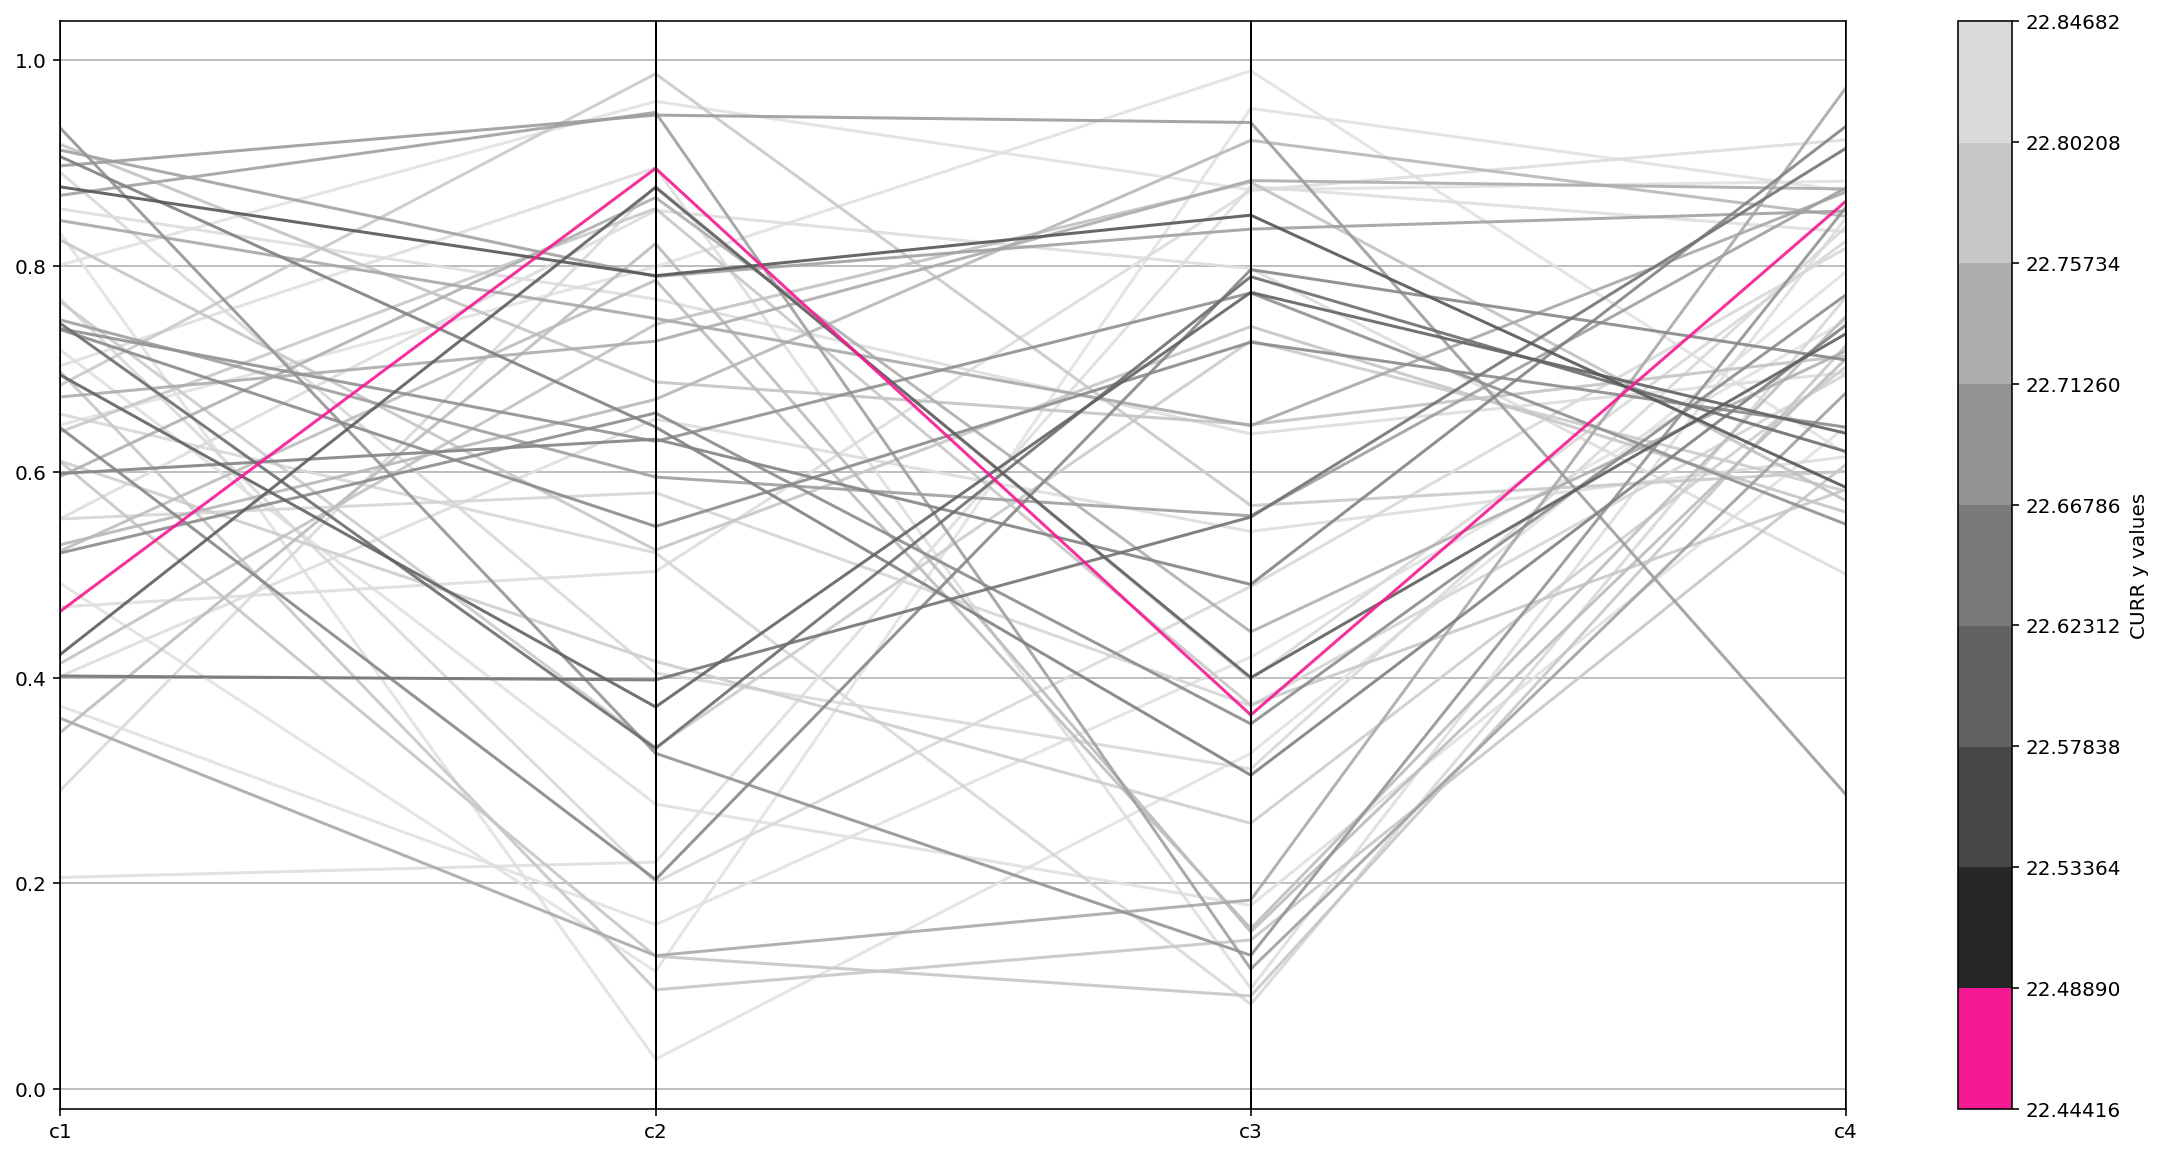

In [15]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pp = parallel_coordinates(data[::-1], 'CURR y', colormap = 'Greys_r')
plt.ylabel("CURR y values")

plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)

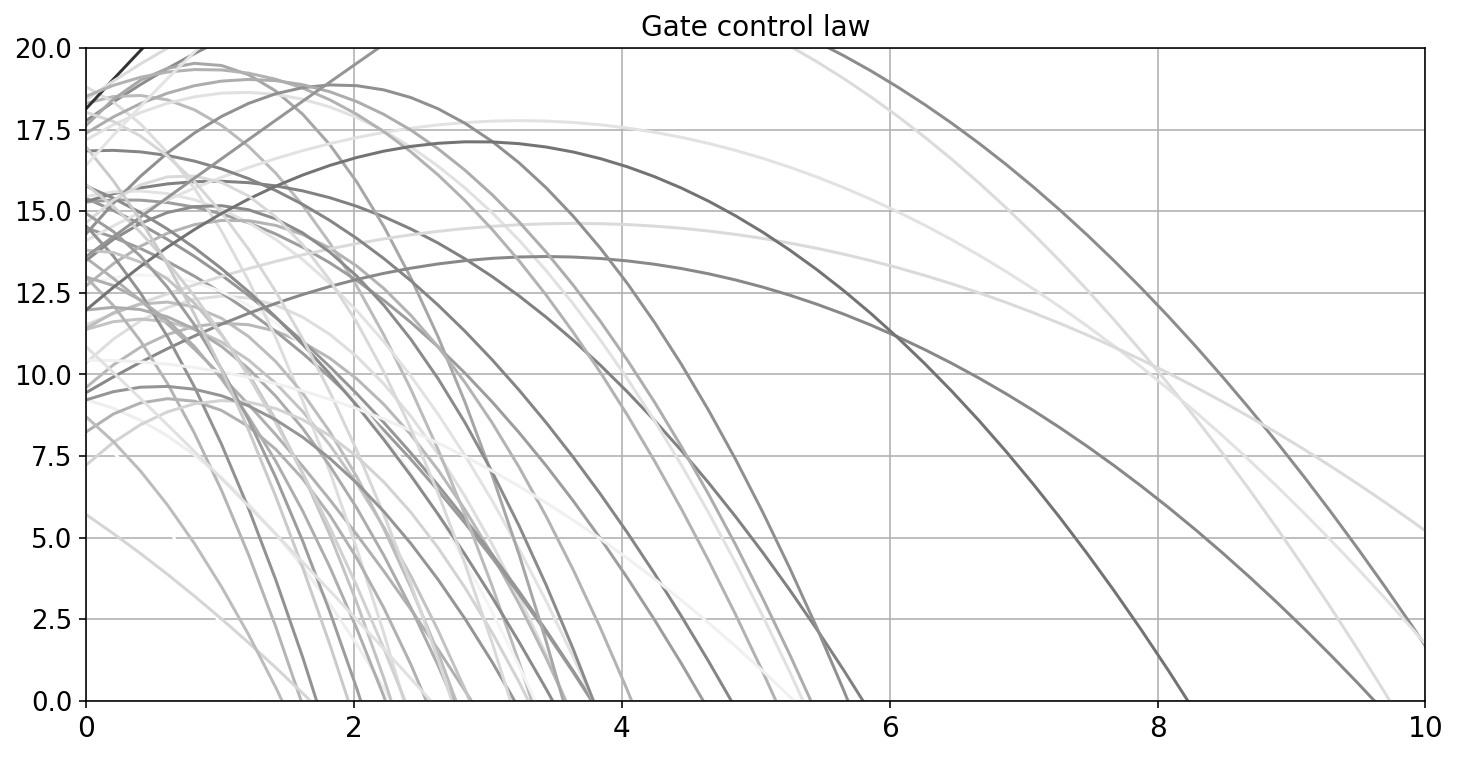

In [16]:
x = np.linspace(0, 20, 100)

n = 50

x4 = data_curs.sort_values(by=['CURR x4'])['CURR x4'].tolist()

for i in range(n):
    y = data_curs.iloc[i]['CURR x'] + data_curs.iloc[i]['CURR x2'] * x + data_curs.iloc[i]['CURR x3'] *x*x
    z = (data_curs.iloc[i]['CURR x4']-x4[0])/(x4[-1]-x4[0])*0.8+0.2
    plt.plot(x, y, c=(z, z, z))
    
    plt.ylim([0, 20])
    plt.xlim([0, 10])
    plt.grid(True)

plt.title('Gate control law', size=14)

fig = plt.gcf()
fig.set_size_inches(12,6)


ax2 = plt.gca()

ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=13)
#plt.yticks(rotation=90)


#plt.yscale('log')
plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)

plt.show()

In [17]:
x4 = np.array(data_curs.sort_values(by=['CURR x4'])['CURR x4'].tolist())
x4b = (x4-x4[0])/(x4[-1]-x4[0])
x4b

array([0.        , 0.31199999, 0.38245166, 0.3995872 , 0.4157163 ,
       0.42941323, 0.43173517, 0.43457573, 0.4573236 , 0.46705807,
       0.47812594, 0.4827054 , 0.48538779, 0.51116195, 0.51982363,
       0.52056065, 0.56840548, 0.594586  , 0.59704376, 0.60521627,
       0.61488785, 0.61651021, 0.62049821, 0.62785483, 0.63525149,
       0.65204119, 0.66425016, 0.67028573, 0.6767591 , 0.70347923,
       0.70707363, 0.73961329, 0.77307782, 0.78318308, 0.79621778,
       0.80312846, 0.81598905, 0.81817537, 0.82559743, 0.83113763,
       0.83952415, 0.85239392, 0.85398158, 0.85679981, 0.85844756,
       0.8677607 , 0.91433681, 0.92629925, 0.94547042, 1.        ])

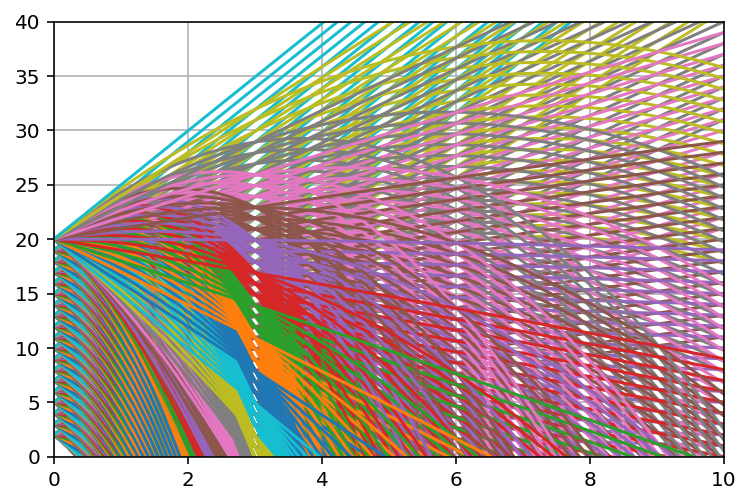

In [18]:
x = np.linspace(0,10,50)
A = np.arange(2, 21)
B = np.arange(-5, 6)
C = np.linspace(-3, -0.01, 10)

for a in A:
    for c in C:
        for b in B:
            plt.plot(x, a+b*x+c*x*x)
            
plt.ylim([0, 40])
plt.xlim([0, 10])
plt.grid(True)
plt.show()